In [10]:
import numpy as np
import matplotlib.pyplot as plt
import math
import csv

##### Volume constant

In [11]:
V = 10e-12
NA = 6.023e23
# sima had V*NA*100e-9*10e-3
vna = V*NA*10e-9*10e-3
ivna = 1/vna

In [12]:
### p is the ODE system vector p=[f1, f2, f3, f4, ..., f19]
#### 0  -> clb1
#### 1  -> clb3
#### 2  -> cdc20T
#### 3  -> cdc20
#### 4  -> clb4
#### 5  -> sp
#### 6  -> cdc5t
#### 7  -> cdc5a 
#### 8  -> ndd1t
#### 9  -> ndd1a
#### 10 -> hcm1
#### 11 -> ndt80
#### 12 -> sum1iIme2
#### 13 -> sum1iCdk1
#### 14 -> sum1iRC
#### 15 -> ama1p
#### 16 -> rc
#### 17 -> dsb
#### 18 -> ama1t

## Parameters

In [13]:
#Synthesis and degradation of Clb1 :
kClb1s = 0.002
kClb1sp = 0.2
kClb1spp = 0.1
kClb1d = 0.1
kClb1dp = 0.2
kClb1dpp = 0.02
#NOTE : Decreasing Clb1 intrinsic decay rate widens Clb3 duration
kClb3s = 0.002
kClb3sp = 0.5
kClb3d = 0.2
kClb3Cdc20d = 0.2
#Cdc20
kCdc20s = 0.2
kCdc20d = 0.1
kCdc20Clb1p = 0.1
kCdc20Clb3p = 0.1
kCdc20a = 0.1
JCdc20Clb3 = 0.1
JCdc20clb1 = 0.1
JCdc20 = 0.1
kClb1Cdc20d = 0.3
kClb3Cdc20d = 0.3
#Clb1 phosophorylation of Cdc20 weaker than Clb3
#Synthesis and degradation of Clb4 :
kClb4s = 0.2
kClb4sp = 0.1
kClb4d = 0.2
kClb4dp = 1
kClb4dpp = 0.02
#Activation and inactivation of SP :
kSPa = 2
kSPi = 2
JSP = 0.01
#Synthesis, degradation, activation, and inactivation of Cdc5 :
kCdc5s = 0.004
kCdc5sp = 0.03
kCdc5spp = 0.02
kCdc5d = 0.02
kCdc5dp = 0.06
kCdc5dpp = 0.002
kCdc5a = 0.1
kCdc5ap = 0.4
kCdc5app = 0.3
kCdc5i = 0.1
#Synthesis, degradation, activation, and inacti - vation of Ndd1 :
kNdd1s = 0.03
kNdd1d = 0.0001
kNdd1dp = 1
kNdd1dpp = 0.02
kNdd1a = 0.1
kNdd1ap = 0.2
kNdd1app = 0.04
kNdd1i = 0.2
JNdd1 = 0.04
#Degradation of Hcm1 :
kHcm1d = 0.02
#Regulation of Ndt80 :
kNdt80s = 0.01
kNdt80sp = 2
kNdt80d = 0.3
JNdt80p = 0.2
alpha = 1
beta = 0.1
ki = 0.01
#degradation of Ndt80 by Ama1 :
kNdt80dp = 0.6
#Regulation of Sum1 :
kSum1i = 0.025
kSum1a = 0.000001
kSum1ip = 0.1
kSum1ipp = 1
kSum1ap = 0.01
kSum1ippp = 0.25
kSum1app = 1
#Regulation of Ama1 :
kAma1a = 0.1
kAma1i = 0.0
kAma1ip = 0.1
JAma1 = 0.1
kAIas = 10
kAIds = 1
kAma1clb3p = 0.1
#Faster rate of Ama1 phosphorylation by Clb1
#Synthesis and degradation of the additional Ama1 - inhibitor (AI) :
kAIs = 0.1
kAId = 0.15
#Activation and inactivation of the RC :
kRCa = 1
kRCi = 0.1
kRCip = 2
JRC = 0.01
#Repair of DSBs :
kDSBi = 0.02
kdmRNA = 0.1
kRim4mRNA = 100
kAma1dp = 0.01
kAma1exp = 0.08
kAma1s = 0.01

## Initial conditions

In [14]:
names = ['clb1','clb3','cdc20T','cdc20','clb4','sp','cdc5t','cdc5a','ndd1t','ndd1a','hcm1','ndt80','sum1iIme2','sum1iCdk1','sum1iRC','ama1p','rc','dsb','ama1t']
p = [0,0,0,0,0,0,0,0,0,0,vna,0,0,0,0,0,0,vna,vna]

proteinCount = {}
for i in range(0,len(names)): proteinCount[names[i]] = p[i]

proteinMap = {
    tuple(np.arange(0,5)): names[0],
    tuple(np.arange(5,9)): names[1],
    tuple(np.arange(9,11)): names[2],
    tuple(np.arange(11,17)): names[3],
    tuple(np.arange(17,21)): names[4],
    tuple(np.arange(21,26)): names[5],
    tuple(np.arange(26,30)): names[6],
    tuple(np.arange(30,39)): names[7],
    # constant rates of change for protiens 8,9
    tuple(np.arange(39,40)): names[10],
    tuple(np.arange(40,44)): names[11],
    tuple(np.arange(44,47)): names[12],
    tuple(np.arange(47,54)): names[13],
    tuple(np.arange(54,57)): names[14],
    tuple(np.arange(57,64)): names[15],
    tuple(np.arange(64,68)): names[16],
    tuple(np.arange(68,69)): names[17],
    tuple(np.arange(69,72)): names[18]
}   

In [15]:
def gillespie_process(T,p,trial):     
    # current time
    t = 0
    
    # histories
    # times = [t]
    # proteins = [p]
    
    while t<T:
        
        # time functions
        kDSBi = 0.02
        Sum1T = 1*vna
        Dmc1 = 1*vna
        Sum1I = lambda t: p[12]*p[13]*p[14]/(Sum1T * Sum1T)
        JNdt80 = lambda t: JNdt80p*(vna+(alpha*(Sum1T-p[12])+beta*(p[12]-Sum1I(t)))/ki)
        Ama1 = lambda t: p[18]-p[15] 
        Rim4 = lambda t: (1-math.tanh(0.2*(t-240)))/2
        
        # propoensities
        # eq1
        p0 = kClb1s*vna
        p1 = kClb1sp*p[11]
        p2 = -kClb1d*p[0]
        p3 = -kClb1dp*Ama1(t)*p[0]*ivna
        p4 = -kClb1Cdc20d*p[3]*p[0]*ivna
        # eq2
        p5 = kClb3s*vna
        p6 = -kClb3d*p[1]
        p7 = -kClb3Cdc20d*p[3]*p[1]*ivna
        p8 = 5*kClb3sp*(vna-Rim4(t)*vna)*math.exp(-(t-240)/25)
        # eq3
        p9 = kCdc20s*vna
        p10 = -kCdc20d*p[2]
        # eq4
        p11 = (kCdc20Clb1p*p[0]*p[2])/(JCdc20clb1*vna+p[2]-p[3])
        p12 = (-kCdc20Clb1p*p[0]*p[3])/(JCdc20clb1*vna+p[2]-p[3])
        p13 = (kCdc20Clb3p*p[1]*p[2])/(JCdc20Clb3*vna+p[2]-p[3])
        p14 = (-kCdc20Clb3p*p[1]*p[3])/(JCdc20Clb3*vna+p[2]-p[3])
        p15 = -kCdc20a*p[3]*vna/(JCdc20*vna+p[3])
        p16 = -kCdc20d*p[3]
        # eq5
        p17 = kClb4s*vna
        p18 = kClb4sp*p[11]
        p19 = -kClb4d*p[4]
        p20 = -kClb4dp*Ama1(t)*p[4]*ivna
        # eq6
        p21 = (kSPa*vna*p[0])/(JSP*vna+vna-p[5])
        p22 = (kSPa*vna*p[4])/(JSP*vna+vna-p[5])
        p23 = -(kSPa*p[0]*p[5])/(JSP*vna+vna-p[5])
        p24 = -(kSPa*p[0]*p[5])/(JSP*vna+vna-p[5])
        p25 = -kSPi*vna*p[5]/(JSP*vna+p[5])
        # eq7
        p26 = kCdc5s*vna
        p27 = kCdc5sp*p[11]
        p28 = kCdc5d*p[6]
        p29 = kCdc5dp*Ama1(t)*p[6]*ivna
        # eq8
        p30 = kCdc5a*p[6]
        p31 = kCdc5ap*p[0]*p[6]*ivna
        p32 = kCdc5app*p[4]*p[6]*ivna
        p33 = -kCdc5a*p[7]
        p34 = -kCdc5ap*p[0]*p[7]*ivna
        p35 = -kCdc5app*p[4]*p[7]*ivna
        p36 = -kCdc5i*p[7]
        p37 = -kCdc5d*p[7]
        p38 = -kCdc5dp*Ama1(t)*p[7]*ivna
        # eq9/eq10 none
        # eq11
        p39 = -kHcm1d*p[10]
        # eq12
        p40 = kNdt80s*vna
        p41 = kNdt80sp*vna*p[11]/(JNdt80(t)+p[11])
        p42 = -kNdt80d*p[11]
        p43 = -kNdt80dp*Ama1(t)*p[11]*ivna
        # eq13
        p44 = kSum1i*Sum1T
        p45 = -kSum1i*p[12]
        p46 = -kSum1a*p[12]
        # eq14
        p47 = kSum1ip*Sum1T 
        p48 = kSum1ipp*Sum1T*p[0]*ivna
        p49 = kSum1ipp*Sum1T*p[4]*ivna
        p50 = -kSum1ip*p[13]
        p51 = -kSum1ipp*p[13]*p[0]*ivna
        p52 = -kSum1ipp*p[13]*p[4]*ivna
        p53 = -kSum1ap*p[13]
        # eq15
        p54 = kSum1ippp*Sum1T
        p55 = -kSum1ippp*p[14]
        p56 = -kSum1app*p[16]*p[14]*ivna
        # eq16
        p57 = (kAma1i*p[18]*vna)/(JAma1*vna+p[18]-p[15])
        p58 = (kAma1ip*p[0]*p[18]*ivna*vna)/(JAma1*vna+p[18]-p[15])
        p59 = (-kAma1i*vna*p[15])/(JAma1*vna+p[18]-p[15])
        p60 = (-kAma1ip*p[0]*p[15]*ivna*vna)/(JAma1*vna+p[18]-p[15])
        p61 = kAma1a*vna*p[15]/(JAma1*vna+p[15])
        p62 = (kAma1clb3p*p[1]*p[18]*ivna*vna)/(JAma1*vna+p[18]-p[15])
        p63 = (-kAma1clb3p*p[1]*p[15]*ivna*vna)/(JAma1*vna+p[18]-p[15])
        # eq17
        p64 = (kRCa*vna*p[17])/(JRC*vna+vna-p[16])
        p65 = (-kRCa*p[17]*p[16])/(JRC*vna+vna-p[16])
        p66 = (-kRCi*vna*p[16])/(JRC*vna+p[16])
        p67 = (-kRCip*p[7]*p[16]*ivna*vna)/(JRC*vna+p[16])
        # eq18
        p68 = -kDSBi*p[17]*Dmc1*ivna
        # eq19
        p69 = kAma1s*vna
        p70 = -kAma1dp*p[18]
        p71 = 40*kAma1s*(vna-Rim4(t)*vna)*math.exp(-(t-240)/100)
        
        # ductape (im so sorry) we wanted abs(n)/n (my fault)
        birthDeathMap = []
        for i in range(0,72):
            sign = str(eval(f'p{i}'))[0]
            if sign == '-': birthDeathMap.append(-1)
            else: birthDeathMap.append(1)
        
        # sum propensities
        props = []
        tot = 0
        for i in range(0,72):
            props.append(abs(eval(f'p{i}')))
        
        props = np.array(props)

        tot = props.sum(axis=0)
         
        partial_sums = []
        for i in range(0,72):
            s = 0
            for j in range(0,i+1):
                s += abs(eval(f'p{j}'))
            partial_sums.append(s)
        
        probs = np.array(partial_sums)/tot        

        # change time
        t = t - np.log(np.random.random())/tot
        
        # write time step to output log
        f = open('time-trials/time-'+str(trial)+'.csv','a+', newline='')
        with f:
            write = csv.writer(f)
            write.writerow([t])
        f.close()
                
        # get a random number
        r = np.random.random()
        
        # get index where r falls in probability ranges
        index = -1
        for i in range(0,72):
            if r <= probs[i]:
                index = i
                break        
        
        for interval in proteinMap.keys():
            if index in interval:
                if proteinCount[proteinMap[interval]] == 0 and birthDeathMap[index] == -1:
                    pass
                else:
                    proteinCount[proteinMap[interval]] += birthDeathMap[index]
        
        # record Gillespie steps
        # times.append(t)
        
        p = []
        for key in proteinCount.keys(): 
            p.append(proteinCount[key])
        
        # proteins.append(p)
        
        # write proteins to a file
        f = open('protein-trials/proteins-trial-'+str(trial)+'.csv', 'a+', newline='')
        with f:
            write = csv.writer(f)
            write.writerow(p)
        f.close()
        
    # return times, proteins

In [16]:
gillespie_process(1,p,0)

In [17]:
def read_times(file):
    times = []
    f = open(file,'r')
    with f:
        reader = csv.reader(f,quotechar='"')
        times = [float(row[0]) for row in reader]
    f.close()
    return times

def read_proteins(file):
    proteins = []
    f = open(file,'r')
    with f:
        reader = csv.reader(f,quotechar='"')
        for row in reader:
            l = []
            for r in row: l.append(float(r))
            proteins.append(l)
    f.close()
    return proteins

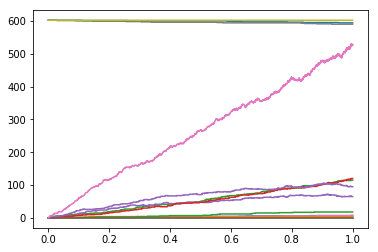

In [18]:
proteins = read_proteins('protein-trials/proteins-trial-0.csv')
times = read_times('time-trials/time-0.csv')
for j in range(0, 19):
    points = []
    for i in range(0, len(proteins)):
        points.append(proteins[i][j])
    plt.plot(times, points)
plt.show()